# Import Libraries

In [1]:
import fitz
import pandas as pd

#Text preprocessing tools
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords,wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem.porter import *

#Similarity checking tools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\User\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Import PDF resumes

In [2]:
import glob
pdf_files=glob.glob('../Resumes\*.pdf')

In [3]:
pdf_files

['../Resumes\\Abiral_Pandey_Fullstack_Java.pdf',
 '../Resumes\\Achyuth Resume_8.pdf',
 '../Resumes\\Adelina_Erimia_PMP1.pdf',
 '../Resumes\\Adhi Gopalam - SM.pdf',
 '../Resumes\\AjayKumar.pdf',
 '../Resumes\\Akhil.profile.pdf',
 '../Resumes\\Akhil_Sr BSA.pdf',
 '../Resumes\\Alekhya Resume.pdf',
 '../Resumes\\Amar Sr BSA.pdf',
 '../Resumes\\Ami Jape.pdf',
 '../Resumes\\Amrinder Business Analyst.pdf',
 '../Resumes\\Amulya Komatineni.pdf',
 '../Resumes\\Anil Krishna Mogalaturthi.pdf',
 '../Resumes\\AnilAgarwal.pdf',
 '../Resumes\\Anudeep N_Sr Java Developer.pdf',
 '../Resumes\\Ashok Jayakumar - PM.pdf',
 '../Resumes\\Ashwini J2EE Developer.pdf',
 '../Resumes\\Atul_Mathur_Resume.pdf',
 '../Resumes\\Avathika BA-Healthcare_.pdf',
 '../Resumes\\avinash G.pdf',
 '../Resumes\\B Shaker-Sr BSA-Scrum Master .pdf',
 '../Resumes\\B Suresh Kumar_Project Manager_1.pdf',
 '../Resumes\\BA - Abhishek.pdf',
 '../Resumes\\BA - Navneet.pdf',
 '../Resumes\\BA Kiran.pdf',
 '../Resumes\\BA with INV.pdf',
 '../

# Resume Text Preprocessing

In [4]:
def getWordnetPos(words):
    tag=pos_tag([words])[0][1][0].upper()
    tag_dict={"J":wordnet.ADJ,
              "N":wordnet.NOUN,
              "V":wordnet.VERB,
              "R":wordnet.ADV
             }
    return tag_dict.get(tag,wordnet.NOUN)

def cv_preprocessing(cv_data):
  #Tokenization
  tokenized_text=word_tokenize(cv_data)

  #Remove stopwords
  stop_words = set(stopwords.words('english'))
  filter_text=[]
  for token in tokenized_text:
    if token not in stop_words:
          filter_text.append(token)

  #POS and lemmatize
  lemmatizer = WordNetLemmatizer()
  lemmatizeResults=[lemmatizer.lemmatize(token,getWordnetPos(token)) for token in filter_text]
  return ' '.join(lemmatizeResults)

def pdftotext(m,preprocessing=False):
  #Open pdf file
  doc=fitz.open(m)

  #Convert pdf to text
  text=''
  for page in doc:
    text+=page.get_text()

  #Remove new line
  text=' '.join(text.split('\n'))

  if preprocessing:
    return cv_preprocessing(text)
  else:
    return text

In [5]:
preprocessed_text=[]
resume_pdf=[]
for i in range(len(pdf_files)):
    resume_pdf.append(pdf_files[i][11:])
    cleaned_text=pdftotext(pdf_files[i],preprocessing=True)
    preprocessed_text.append(cleaned_text)

#Preprocessed resume
resume_preprocessed_data={'Resume Filename':resume_pdf,'Preprocessed Resume':preprocessed_text}
#Insert resume data into dataframe
df_preprocessed_resume=pd.DataFrame(resume_preprocessed_data)

In [6]:
df_preprocessed_resume

,Resume Filename,Preprocessed Resume
0,Abiral_Pandey_Fullstack_Java.pdf,Name : Abiral Pandey Email : abiral.pandey88 @...
1,Achyuth Resume_8.pdf,Achyuth 540-999-8048 achyuth.java88 @ gmail.co...
2,Adelina_Erimia_PMP1.pdf,"Adelina Erimia , PMP , Six Sigma Green Belt , ..."
3,Adhi Gopalam - SM.pdf,Adhi Gopalam adhigopalam @ gmail.com 281-212-3...
4,AjayKumar.pdf,Page1of 8 Ajay Kumar ( CSM ) Email/Skype : aja...
...,...,...
219,Vishnu Java dev.pdf,VISHNU J Email jammigumpulavishnu452 @ gmail.c...
220,Vivek Joshi_CV.pdf,Cell : 972-514-3667 Vivek Joshi Business Analy...
221,Vivek.BSA.pdf,VIVEK SAGAR Sr. BUSINESS SYSTEM ANALYST PROFES...
222,Yohan BSA.pdf,"YOHAN Sr. Business Analyst Versatile , effecti..."


In [7]:
df_preprocessed_resume['Preprocessed Resume']

0      Name : Abiral Pandey Email : abiral.pandey88 @...
1      Achyuth 540-999-8048 achyuth.java88 @ gmail.co...
2      Adelina Erimia , PMP , Six Sigma Green Belt , ...
3      Adhi Gopalam adhigopalam @ gmail.com 281-212-3...
4      Page1of 8 Ajay Kumar ( CSM ) Email/Skype : aja...
                             ...                        
219    VISHNU J Email jammigumpulavishnu452 @ gmail.c...
220    Cell : 972-514-3667 Vivek Joshi Business Analy...
221    VIVEK SAGAR Sr. BUSINESS SYSTEM ANALYST PROFES...
222    YOHAN Sr. Business Analyst Versatile , effecti...
223    Yugesh +1 ( 515 ) -650-2459 yugeshm4 @ gmail.c...
Name: Preprocessed Resume, Length: 224, dtype: object

# Similarity Resume Checking

In [11]:
def similarity_resume_checking():
    while(True):
        flagFound=False
        search_filename=input('Input the filename you want to search for the similarity: ')
        for i in range(len(df_preprocessed_resume)):
            if df_preprocessed_resume.iloc[i]['Resume Filename'].strip()==search_filename.strip():
                inputFileContent= df_preprocessed_resume.iloc[i]['Preprocessed Resume']
                flagFound=True
                break

        if flagFound==False:
            print('Sorry no such resume PDF found')
            ctn=input('\nDo you want to continue search ? (Y/N) >> ')
            if ctn=='N' or ctn=='n':
                break
        else:
            break
            
    similary_score={}
    for i in df_preprocessed_resume['Resume Filename']:
        vectorizer=TfidfVectorizer()
        tf_matrix=vectorizer.fit_transform([i,inputFileContent])
        match_percentage=round((cosine_similarity(tf_matrix)[0][1])*100,2)
        if match_percentage!=0.00:
            similary_score[match_percentage]=i
    
    print('\nSimilarity Resume Checking')
    print('------------------------------')
    print('Resume - ',search_filename,' similarity content with other resumes')
    print('==============================================================================')
    for i in sorted(similary_score.keys())[::-1]:
        print(f'Resume - {similary_score[i]:50} match {i:5}%')
        
similarity_resume_checking()

Input the filename you want to search for the similarity: Yugesh_Resume.pdf

Similarity Resume Checking
------------------------------
Resume -  Yugesh_Resume.pdf  similarity content with other resumes
Resume - Niteesh Java Developer.pdf                         match  7.22%
Resume - vikas java.pdf                                     match  6.47%
Resume - Sumanth Manne Java Developer.pdf                   match  6.26%
Resume - Pavan Kumar Full Stack Java Developer.pdf          match   6.1%
Resume - Vishnu Java dev.pdf                                match  5.47%
Resume - Ashwini J2EE Developer.pdf                         match  3.74%
Resume - Business Analyst_GHyma.pdf                         match  3.03%
Resume - Sr. Business Analyst.pdf                           match  2.56%
Resume - RAMYA BUSINESS ANALYST RESUME.pdf                  match  2.26%
Resume - Pavan Sr Business Analyst resume.pdf               match  2.05%
Resume - SUNITHA Project Manager (1).pdf                    match  1

In [23]:
def similarity_job_descriptions():
    flagFound=False
    job_description=input('Enter job descriptions to search for the similarity: ')
            
    similary_score={}
    for i in range(len(df_preprocessed_resume['Resume Filename'])):
        vectorizer=TfidfVectorizer()
        tf_matrix=vectorizer.fit_transform([df_preprocessed_resume.iloc[i]['Preprocessed Resume'],job_description])
        match_percentage=round((cosine_similarity(tf_matrix)[0][1])*100,2)
        if match_percentage!=0.00:
            similary_score[match_percentage]=i
    
    print('==============================================================================')
    print('\t\t Job descriptiona similarity scores')
    print('==============================================================================')
    for i in sorted(similary_score.keys())[::-1]:
        print(f'{similary_score[i]:4} match {i:5}%')
        
similarity_job_descriptions()

Enter job descriptions to search for the similarity: Strong experience in database design using PL/SQL to write tables, Stored Procedures, Functions, Triggers, Indexers  and proficiency in writing complex queries to retrieve data.
		 Job descriptiona similarity scores
  83 match 14.31%
  39 match 12.63%
 174 match 12.08%
 207 match  11.8%
 133 match 11.72%
 211 match 11.38%
  28 match 11.31%
  64 match 11.27%
 182 match 11.04%
  35 match 10.96%
 222 match 10.93%
 196 match 10.89%
  65 match 10.83%
  40 match 10.71%
  19 match 10.63%
 102 match 10.54%
  47 match 10.33%
 195 match 10.26%
   8 match 10.18%
  84 match 10.13%
 129 match 10.08%
 223 match  9.99%
  54 match  9.96%
 104 match  9.83%
 134 match  9.67%
 115 match  9.64%
 219 match  9.63%
 110 match  9.62%
 111 match   9.6%
 172 match  9.59%
  51 match  9.48%
 137 match  9.44%
 139 match  9.32%
  67 match  9.28%
  38 match  9.25%
 105 match  9.23%
  81 match   9.2%
  56 match  9.13%
 159 match  9.08%
  42 match  9.02%
 109 match 

# LDA Topic Modeling - Search keywords

In [12]:
pdf_files = glob.glob('../Resumes\*.pdf')
# pdf_files = ['R1.pdf', 'R2.pdf', 'R3.pdf', 'R4.pdf', 'R5.pdf']

# Create an empty list to store the text from each PDF file
pdf_texts = []

#Convert the pdf to dataframe
def pdf_to_text(document):
    doc = fitz.open(document)
    text = ""
    for page in doc:
       text += page.get_text()
    return text

# Loop over each PDF file name, call the pdftotext function, and append the resulting text to the pdf_texts list
for pdf_file in pdf_files:
    text = pdf_to_text(pdf_file)
    pdf_texts.append(text)

# Concatenate the pdf_texts list into a single DataFrame
#df = pd.DataFrame(pdf_texts, columns=['resume'])
df = pd.DataFrame({'file_name': pdf_files, 'resume': pdf_texts})

In [13]:
# Load the resumes data
resumes = df

In [14]:
df

,file_name,resume
0,../Resumes\Abiral_Pandey_Fullstack_Java.pdf,Name: Abiral Pandey \nEmail: abiral.pandey88@g...
1,../Resumes\Achyuth Resume_8.pdf,Achyuth \n540-999-8048 \nachyuth.java88@gmail....
2,../Resumes\Adelina_Erimia_PMP1.pdf,"Adelina Erimia, PMP, Six Sigma Green Belt, SMC..."
3,../Resumes\Adhi Gopalam - SM.pdf,\n \nAdhi Gopalam \nadhigopalam@gmail.com \n2...
4,../Resumes\AjayKumar.pdf,\n \n Page1of 8 \nAjay Kumar (CSM) \n \...
...,...,...
219,../Resumes\Vishnu Java dev.pdf,\n \n \nVISHNU J \nEmail to jammigumpulavishn...
220,../Resumes\Vivek Joshi_CV.pdf,Cell: 972-514-3667 \n \n \n \nVivek Joshi \nBu...
221,../Resumes\Vivek.BSA.pdf,VIVEK SAGAR ...
222,../Resumes\Yohan BSA.pdf,"YOHAN \nSr. Business Analyst \n \nVersatile, ..."


In [15]:
# Define the stemmer and lemmatizer
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

# Define a function for preprocessing the resumes
def preprocess(resume):
    result = []
    for word in simple_preprocess(resume):
        if word not in STOPWORDS:
            result.append(stemmer.stem(lemmatizer.lemmatize(word, pos='v')))
    return result

In [16]:
# Preprocess the resumes
processed_resumes = resumes['resume'].map(preprocess)

In [17]:
preprocess

<function __main__.preprocess(resume)>

In [18]:
resumes

,file_name,resume
0,../Resumes\Abiral_Pandey_Fullstack_Java.pdf,Name: Abiral Pandey \nEmail: abiral.pandey88@g...
1,../Resumes\Achyuth Resume_8.pdf,Achyuth \n540-999-8048 \nachyuth.java88@gmail....
2,../Resumes\Adelina_Erimia_PMP1.pdf,"Adelina Erimia, PMP, Six Sigma Green Belt, SMC..."
3,../Resumes\Adhi Gopalam - SM.pdf,\n \nAdhi Gopalam \nadhigopalam@gmail.com \n2...
4,../Resumes\AjayKumar.pdf,\n \n Page1of 8 \nAjay Kumar (CSM) \n \...
...,...,...
219,../Resumes\Vishnu Java dev.pdf,\n \n \nVISHNU J \nEmail to jammigumpulavishn...
220,../Resumes\Vivek Joshi_CV.pdf,Cell: 972-514-3667 \n \n \n \nVivek Joshi \nBu...
221,../Resumes\Vivek.BSA.pdf,VIVEK SAGAR ...
222,../Resumes\Yohan BSA.pdf,"YOHAN \nSr. Business Analyst \n \nVersatile, ..."


In [19]:
processed_resumes

0      [abir, pandey, email, abir, pandey, gmail, com...
1      [achyuth, achyuth, java, gmail, com, object, y...
2      [adelina, erimia, pmp, sigma, green, belt, smc...
3      [adhi, gopalam, adhigopalam, gmail, com, certi...
4      [page, ajay, kumar, csm, email, skype, ajaydt,...
                             ...                        
219    [vishnu, email, gmail, com, contact, senior, j...
220    [cell, vivek, joshi, busi, analyst, bellevu, w...
221    [vivek, sagar, sr, busi, analyst, profession, ...
222    [yohan, sr, busi, analyst, versatil, effect, p...
223    [yugesh, yugeshm, gmail, com, profession, summ...
Name: resume, Length: 224, dtype: object

In [20]:
# Create a dictionary from the preprocessed resumes
dictionary = corpora.Dictionary(processed_resumes)
dictionary

In [21]:
# Create a corpus from the dictionary and preprocessed resumes
corpus = [dictionary.doc2bow(resume) for resume in processed_resumes]
corpus

[[(0, 2),
  (1, 1),
  (2, 3),
  (3, 1),
  (4, 1),
  (5, 2),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 2),
  (11, 2),
  (12, 5),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 2),
  (18, 1),
  (19, 1),
  (20, 5),
  (21, 3),
  (22, 1),
  (23, 5),
  (24, 2),
  (25, 6),
  (26, 2),
  (27, 1),
  (28, 20),
  (29, 2),
  (30, 7),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 2),
  (35, 1),
  (36, 1),
  (37, 2),
  (38, 1),
  (39, 1),
  (40, 2),
  (41, 1),
  (42, 2),
  (43, 1),
  (44, 7),
  (45, 2),
  (46, 1),
  (47, 5),
  (48, 2),
  (49, 1),
  (50, 1),
  (51, 3),
  (52, 8),
  (53, 9),
  (54, 1),
  (55, 1),
  (56, 7),
  (57, 2),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 7),
  (65, 1),
  (66, 3),
  (67, 3),
  (68, 8),
  (69, 1),
  (70, 2),
  (71, 4),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 5),
  (79, 1),
  (80, 7),
  (81, 5),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 8),
  (86, 1),
  (87, 2),
  (88, 1),
  (89, 1),
  (90, 11),
  (91, 

In [22]:
# Train the LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=5,
                     random_state=42,
                     chunksize=100,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)

# Print the topics and their top keywords
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nKeywords: {}'.format(idx, topic))

Topic: 0 
Keywords: 0.038*"project" + 0.037*"manag" + 0.014*"team" + 0.009*"plan" + 0.009*"client" + 0.008*"develop" + 0.008*"support" + 0.007*"busi" + 0.007*"report" + 0.006*"applic"
Topic: 1 
Keywords: 0.034*"data" + 0.015*"hadoop" + 0.014*"spark" + 0.013*"hive" + 0.012*"develop" + 0.009*"oracl" + 0.009*"databas" + 0.007*"work" + 0.007*"big" + 0.007*"integr"
Topic: 2 
Keywords: 0.002*"chubb" + 0.001*"itec" + 0.001*"orca" + 0.001*"survivorship" + 0.001*"bbbi" + 0.001*"pencil" + 0.001*"iw" + 0.001*"synon" + 0.001*"peertask" + 0.001*"idhunammakadai"
Topic: 3 
Keywords: 0.028*"develop" + 0.020*"applic" + 0.020*"spring" + 0.017*"web" + 0.016*"servic" + 0.014*"java" + 0.011*"design" + 0.011*"implement" + 0.010*"test" + 0.009*"server"
Topic: 4 
Keywords: 0.023*"busi" + 0.022*"test" + 0.020*"requir" + 0.015*"project" + 0.015*"data" + 0.014*"develop" + 0.012*"document" + 0.012*"manag" + 0.011*"team" + 0.011*"ms"


In [23]:
# Assign the most probable topic to each resume
for i, resume in enumerate(processed_resumes):
    print('Resume {}: Topic {}'.format(i, lda_model.get_document_topics(corpus[i])[0][0]))

Resume 0: Topic 3
Resume 1: Topic 3
Resume 2: Topic 0
Resume 3: Topic 0
Resume 4: Topic 0
Resume 5: Topic 4
Resume 6: Topic 4
Resume 7: Topic 3
Resume 8: Topic 1
Resume 9: Topic 0
Resume 10: Topic 4
Resume 11: Topic 3
Resume 12: Topic 0
Resume 13: Topic 0
Resume 14: Topic 3
Resume 15: Topic 0
Resume 16: Topic 0
Resume 17: Topic 0
Resume 18: Topic 1
Resume 19: Topic 0
Resume 20: Topic 3
Resume 21: Topic 0
Resume 22: Topic 0
Resume 23: Topic 0
Resume 24: Topic 4
Resume 25: Topic 0
Resume 26: Topic 0
Resume 27: Topic 0
Resume 28: Topic 1
Resume 29: Topic 0
Resume 30: Topic 0
Resume 31: Topic 4
Resume 32: Topic 3
Resume 33: Topic 0
Resume 34: Topic 3
Resume 35: Topic 3
Resume 36: Topic 0
Resume 37: Topic 0
Resume 38: Topic 0
Resume 39: Topic 0
Resume 40: Topic 0
Resume 41: Topic 4
Resume 42: Topic 0
Resume 43: Topic 0
Resume 44: Topic 0
Resume 45: Topic 0
Resume 46: Topic 0
Resume 47: Topic 3
Resume 48: Topic 0
Resume 49: Topic 0
Resume 50: Topic 3
Resume 51: Topic 3
Resume 52: Topic 3
Res

In [24]:
processed_resumes

0      [abir, pandey, email, abir, pandey, gmail, com...
1      [achyuth, achyuth, java, gmail, com, object, y...
2      [adelina, erimia, pmp, sigma, green, belt, smc...
3      [adhi, gopalam, adhigopalam, gmail, com, certi...
4      [page, ajay, kumar, csm, email, skype, ajaydt,...
                             ...                        
219    [vishnu, email, gmail, com, contact, senior, j...
220    [cell, vivek, joshi, busi, analyst, bellevu, w...
221    [vivek, sagar, sr, busi, analyst, profession, ...
222    [yohan, sr, busi, analyst, versatil, effect, p...
223    [yugesh, yugeshm, gmail, com, profession, summ...
Name: resume, Length: 224, dtype: object

In [25]:
# Assign the most probable topic to each resume
resumes['topic'] = processed_resumes.apply(lambda x: lda_model.get_document_topics(dictionary.doc2bow(x))[0][0])

# Print the resume index and its assigned topic
print(resumes[['resume', 'topic']])

                                                resume  topic
0    Name: Abiral Pandey \nEmail: abiral.pandey88@g...      3
1    Achyuth \n540-999-8048 \nachyuth.java88@gmail....      3
2    Adelina Erimia, PMP, Six Sigma Green Belt, SMC...      0
3     \n \nAdhi Gopalam \nadhigopalam@gmail.com \n2...      0
4     \n \n Page1of 8 \nAjay Kumar (CSM)       \n \...      0
..                                                 ...    ...
219   \n \n \nVISHNU J \nEmail to jammigumpulavishn...      3
220  Cell: 972-514-3667 \n \n \n \nVivek Joshi \nBu...      0
221  VIVEK SAGAR                                   ...      3
222  YOHAN  \nSr. Business Analyst \n \nVersatile, ...      1
223  Yugesh \n+1(515)-650-2459 \nyugeshm4@gmail.com...      3

[224 rows x 2 columns]


In [26]:
# Define a function for searching resumes based on a keyword
def search_resumes(keyword):
    # Preprocess the keyword
    keyword = preprocess(keyword.lower())
    # Create a boolean mask that filters the resumes containing the keyword
    mask = processed_resumes.apply(lambda x: any(word in x for word in keyword))

    # Use the boolean mask to select rows in the original DataFrame
    filtered_resumes = resumes.loc[mask, :]

    # Assign the most probable topic to each filtered resume
    filtered_resumes['resume'].map(lambda x: lda_model.get_document_topics(dictionary.doc2bow(preprocess(x)))[0][0])

    # Assign the most probable topic to each filtered resume
    filtered_resumes['topic'] = filtered_resumes['resume'].map(lambda x: lda_model.get_document_topics(dictionary.doc2bow(preprocess(x)))[0][0])
    filtered_resumes.loc[:, 'topic'] = filtered_resumes['resume'].map(lambda x: lda_model.get_document_topics(dictionary.doc2bow(preprocess(x)))[0][0])
    # Print the top 10 filtered resumes
    top_resumes = filtered_resumes.sort_values(by='topic', ascending=False).head(10)
    for index, row in top_resumes.iterrows():
        print('Topic: {}\nFile: {}\n'.format(row['topic'], row['file_name']))

In [27]:
# Ask the user for a keyword to search for
keyword = input('Enter a keyword to search for: ')
# Search for resumes based on the keyword and display the results
search_resumes(keyword)

Enter a keyword to search for: project
Topic: 4
File: ../Resumes\Madhuri Pawar.pdf

Topic: 4
File: ../Resumes\Mounika health care resume.pdf

Topic: 4
File: ../Resumes\ParthMPatel_BA.pdf

Topic: 4
File: ../Resumes\Sr. Business Analyst.pdf

Topic: 4
File: ../Resumes\BA Kiran.pdf

Topic: 4
File: ../Resumes\Brahma-Resume (BA).pdf

Topic: 4
File: ../Resumes\Ujvala BA Feb 20.pdf

Topic: 4
File: ../Resumes\Utthan Silawal12.pdf

Topic: 4
File: ../Resumes\Dhanalaxmi -BA.pdf

Topic: 4
File: ../Resumes\Spoorthi Finance BSA Resume.pdf



# Resume EDA

### WordCloud

In [28]:
def wordcloud(cv_data):
  print('\n')
  wordcloud=WordCloud(background_color='white',width=1600,height=800).generate(cv_data)
  plt.figure(figsize=(10,5),facecolor='k')
  plt.title('Resume WordNet Visualization')
  plt.axis('off')
  #Display the generated img
  plt.imshow(wordcloud,interpolation='bilinear')

### N-grams

In [49]:
colors = ['#9966ff', '#3399ff', '#00ff00', '#ff6600']
def get_top_ngrams(corpus, ngram_range, n=None):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    
    sum_words = bag_of_words.sum(axis=0)
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    common_words = words_freq[:n]
    words = []
    freqs = []
    for word, freq in common_words:
        words.append(word)
        freqs.append(freq)
        
    df = pd.DataFrame({'Word': words, 'Freq': freqs})
    return df

def ngrams(df:object):
    n = 20

    trigrams = get_top_ngrams(df['Preprocessed Resume'], (3, 3), n)
    
    #Trigrams
    print('=====================================================================')
    print(f'\t\t     Trigrams Visualization')
    print('=====================================================================')
    plt.figure(figsize=(8, 10))
    sns.barplot(x='Freq', y='Word', color=colors[3], data=trigrams)
    plt.title('Top 20 Trigrams', size=15)
    plt.show()

In [30]:
def resume_eda():
    while(True):
        flagFound=False
        search_filename=input('Input the filename you want to visualize : ')
        for i in range(len(df_preprocessed_resume)):
            if df_preprocessed_resume.iloc[i]['Resume Filename'].strip()==search_filename.strip():
                inputFileContent= df_preprocessed_resume.iloc[i]['Preprocessed Resume']
                flagFound=True
                break

        if flagFound==False:
            print('Sorry no such resume PDF found')
            ctn=input('\nDo you want to continue search ? (Y/N) >> ')
            if ctn=='N' or ctn=='n':
                break
        else:
            break
    return inputFileContent

Input the filename you want to visualize : Yugesh_Resume.pdf




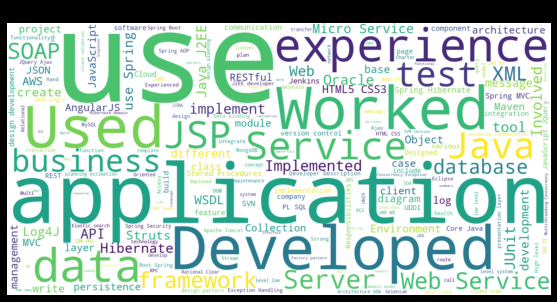

In [33]:
cv_data=resume_eda()
wordcloud(cv_data)

		     Trigrams Visualization


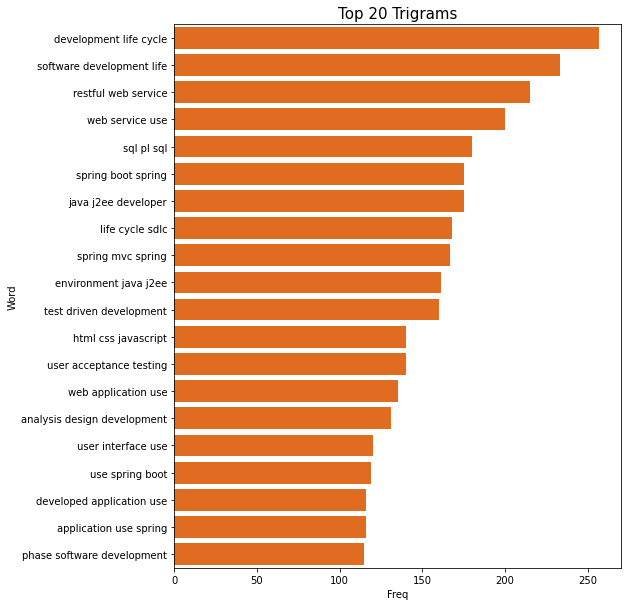

In [50]:
ngrams(df_preprocessed_resume)